<h1 align="center">PyTorch Practice<h1>

# First Project `MNIST`

## Import the libraries

In [1]:
import torch
from torch import nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm.auto import tqdm


## Import the dataset and prepare it

**Note:** mean and standard deviation of the MNIST dataset are -> `mean=(0.1307,), std=(0.3081)`

The `DataLoader` class is used to load the data in batches, which can improve the performance and memory usage of the training process.

In [2]:
# load the train dataset
train_data = datasets.MNIST(root="data",
                       download=True,
                       train=True,
                       transform=transforms.ToTensor())
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)

# load the test dataset
test_data = datasets.MNIST(root="data",
                      download=True,
                      train=False,
                      transform=transforms.ToTensor())
testloader = DataLoader(test_data, batch_size=64, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [4]:
# check the classes
img, label = train_data[0]
#img, label

In [5]:
# check the shape
img.shape

torch.Size([1, 28, 28])

In [6]:
torch.randint(0, len(train_data), size=[1]).item()

8788

**Display the image**

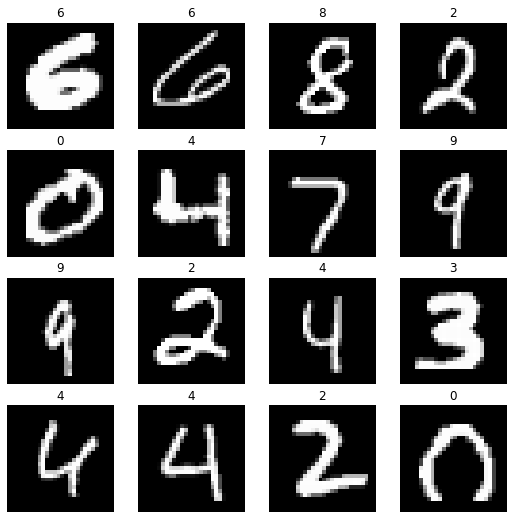

In [7]:
# display the random images
torch.manual_seed(42)

fig = plt.figure(figsize=(9,9))
r, c = 4, 4
for i in range(1, r*r+1):
  random_ind = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_ind]
  fig.add_subplot(r, c, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(label)
  plt.axis(False)

In [8]:
data,target = next(iter(trainloader))
data.shape

torch.Size([64, 1, 28, 28])

Image size: torch.Size([1, 28, 28])


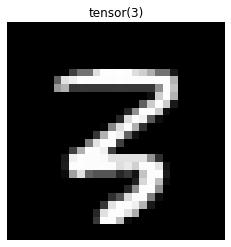

In [9]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(data), size=[1]).item()
img = data[random_idx] 
plt.imshow(img.squeeze(), cmap="gray")
plt.title(target[random_idx])
plt.axis("Off");
print(f"Image size: {img.shape}")

## Train the model

In [10]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class Mnist(nn.Module):
  
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=4,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4)
    )
    self.block2 = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*6*6,
                  out_features=output_shape),
        #nn.Softmax()
    )
  
  def forward(self, x:torch.Tensor):
    x = self.block1(x)
    #print(x.shape)
    x = self.block2(x)

    return x

model = Mnist(input_shape=1,
              hidden_units=64,
              output_shape=len(train_data.classes)).to(device)
model

Mnist(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=10, bias=True)
  )
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
epochs = 2

for epoch in tqdm(range(epochs)):
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(trainloader):
      # Send data to GPU
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate loss
      loss = criterion(y_pred, y)
      train_loss += loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(trainloader)
  train_acc /= len(trainloader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  # Turn on inference context manager
  with torch.inference_mode(): 
      for X, y in testloader:
          # Send data to GPU
          X, y = X.to(device), y.to(device)
            
          # 1. Forward pass
          test_pred = model(X)
            
          # 2. Calculate loss and accuracy
          test_loss += criterion(test_pred, y)
          test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1))
        
      # Adjust metrics and print out
      test_loss /= len(testloader)
      test_acc /= len(testloader)
      print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

  0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.27173 | Train accuracy: 91.94%
Test loss: 0.11369 | Test accuracy: 96.73%

Train loss: 0.09935 | Train accuracy: 97.13%
Test loss: 0.07012 | Test accuracy: 97.90%

